# Process Data
In this notebook, we show the processing steps of the data.  
The raw data can be requested at https://journals.aps.org/datasets, where the introduction of data can also be acquired.  
In the **structralize source data** section, we handle the raw json files into a structured data table of paper information.  
In the **count 5-year citations** section, we count the citations each paper received in five years after its publication, then we take the log-citations as our evaluation metrics of scholar impact.  
In the **assgin areas and topics** section, we assgin the PACS code to each paper.  
In the **name disambiguation** section, we do name disambiguation for authors using their public information. Thus we can have an accurate publication list for each author.  
In the **EP&ED** section, we show our calculation process of exploratory propensity(EP) and exploratory distance(ED) based on PACS codes.  
In the **select scientists** section, we select authors who have at least 10 publications as our study objects.


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tqdm
from collections import Counter
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib
import statistics 
import math
import pickle
import scipy.io as scio
import json
import os
import datetime
import sys

def save_pkl(path,obj):
    with open(path, 'wb') as f:
        pickle.dump(obj,f)
        
def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

print(os.listdir())

['5_1_PSW.R', '6_temporal_perspectives.ipynb', 'draw', '3_sample_scientist.ipynb', '2_interplays.ipynb', '4_regression_result.ipynb', '.ipynb_checkpoints', '5_2_PSW_result.ipynb', '1_processed_data.ipynb', '__pycache__']


## structuralize source data

In [2]:
paper_doi = []
authors_name = []
dates = []
paper_type =[]
for pairs in tqdm.tqdm(os.walk("../raw_data/aps-dataset-metadata-2020/", topdown=False)):# the path where you put the source file from APS
    root = pairs[0]
    files = pairs[2]
    for name in files:
        path = os.path.join(root, name)
        author_name = []
        with open(path, 'r') as f:   #read json files
            data = json.load(f)  
            
            date_list = list(map(int,data['date'].split('-')))
            date = datetime.date(date_list[0],date_list[1],date_list[2])
            dates.append(date)
            
            paper_doi.append(data['id'])
            
            if 'articleType' in data.keys():
                paper_type.append(data['articleType'])
            else:
                paper_type.append(None)
                
            if 'authors' in data.keys():
                for i in range(len(data['authors'])):
                    author_name.append(data['authors'][i]['name'])
            else:
                author_name = None
            authors_name.append(author_name)

1031it [19:28,  1.13s/it]


In [4]:
meta_paper_data = pd.DataFrame({
    'paperDoi':paper_doi,
    'authorName':authors_name,
    'date':dates,
    'type':paper_type
})
# save_pkl('../data/processing_data/meta_paper_data.pkl', meta_paper_data) # if you want to save the file, uncomment the line:)

In [5]:
meta_paper_data.date.min(),meta_paper_data.date.max(),len(meta_paper_data)

(datetime.date(1893, 7, 1), datetime.date(2020, 12, 31), 678961)

## count five-year citations

In [6]:
# meta_paper_data = load_pkl('./meta_paper_data.pkl') # if you want to read the file, uncomment the line:)
doi_date = dict(zip(meta_paper_data.paperDoi,meta_paper_data.date))
cit_pair = pd.read_csv('../raw_data/aps-dataset-citations-2020.csv') # the path where you put the source file from APS
cit_pair_with_time = pd.merge(cit_pair, meta_paper_data[['paperDoi','date']].rename(columns={'paperDoi':'citing_doi','date':'citing_pubdate'}), on='citing_doi', how='left').drop_duplicates()
cit_pair_with_time = pd.merge(cit_pair_with_time, meta_paper_data[['paperDoi','date']].rename(columns={'paperDoi':'cited_doi','date':'cited_pubdate'}), on='cited_doi', how='left').drop_duplicates()
cit_pair_with_time = cit_pair_with_time.dropna().reset_index(drop=True)# delete record without time

In [7]:
n = 5 # time windows for citation count
citation_dict = {}
reference_dict = {}

for i in tqdm.tqdm(range(len(cit_pair_with_time))):
    cited_pub_i = cit_pair_with_time.cited_pubdate.iloc[i]
    citing_pub_i = cit_pair_with_time.citing_pubdate.iloc[i]
    delta = citing_pub_i-cited_pub_i
    cited_doi_i = cit_pair_with_time.cited_doi.iloc[i]
    citing_doi_i = cit_pair_with_time.citing_doi.iloc[i]
    
    #for cited list
    if (delta>=datetime.timedelta(days=0))&(delta<=datetime.timedelta(days=n*365)): ##5years= 365*5 days
        if cited_doi_i in citation_dict.keys():
            citation_dict[cited_doi_i].add(citing_doi_i)
        else:
            citation_dict[cited_doi_i] = set([citing_doi_i])

    #for reference list
    if citing_doi_i in reference_dict.keys():
        reference_dict[citing_doi_i].add(cited_doi_i)
    else:
        reference_dict[citing_doi_i] = set([cited_doi_i])

100%|██████████| 8767868/8767868 [05:15<00:00, 27815.33it/s]


In [9]:
meta_paper_data = meta_paper_data.drop_duplicates(subset=['paperDoi', 'date'])
citations = []
references = []
cit_count =[]
ref_count = []
for i in tqdm.tqdm(range(len(meta_paper_data))):
    paperdoi = meta_paper_data.paperDoi.iloc[i]
    if paperdoi in citation_dict.keys():
        citations.append(citation_dict[paperdoi])
        cit_count.append(len(citation_dict[paperdoi]))
    else:
        citations.append(set([]))
        cit_count.append(0)
    if paperdoi in reference_dict.keys():
        references.append(reference_dict[paperdoi])
        ref_count.append(len(reference_dict[paperdoi]))
    else:
        references.append(set([]))
        ref_count.append(0)

meta_paper_data_2 = meta_paper_data.copy()
meta_paper_data_2['citations'] = citations
meta_paper_data_2['citCount'] = cit_count
meta_paper_data_2['references'] = references
meta_paper_data_2['refCount'] = ref_count

meta_paper_data_2 = meta_paper_data_2.drop_duplicates(subset=['paperDoi', 'date']).reset_index(drop = True)
save_pkl('../data/processing_data/meta_paper_data_2.pkl',meta_paper_data_2)

100%|██████████| 678916/678916 [00:06<00:00, 98541.31it/s] 


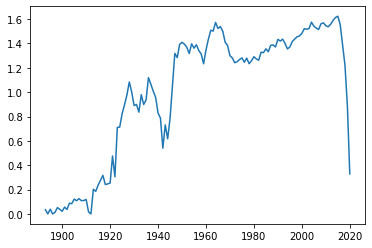

In [11]:
meta_paper_data_2['logCit'] = [np.log(i+1) for i in meta_paper_data_2['citCount']]
meta_paper_data_2['year'] = [i.year for i in meta_paper_data_2['date']]
plt.plot(meta_paper_data_2.groupby('year').logCit.mean())

## assgin areas and topics

In [12]:
PACS = pd.read_csv('/public/aps/raw_data/PACS.txt', keep_default_na=False)
def get_genre(name):
    PACS_code = []
    for i in tqdm.tqdm(range(len(PACS))):
        p_code = re.match(r'((.*)([0-9]{4})(.*))', str(PACS[name].iloc[i]).replace('.','').replace(' ','').replace(':',''))
        if p_code:
            if p_code.group(1)[:2].isdigit():
                PACS_code.append(p_code.group(1)[:6].replace('−','-').replace('–','-'))
            else:
                PACS_code.append(None)
        else:
            PACS_code.append(None)
    return PACS_code

genres_set = set(get_genre('PACS1') + get_genre('PACS2') + get_genre('PACS3') + get_genre('PACS4') + get_genre('PACS5'))

PACS1 = get_genre('PACS1')
PACS2 = get_genre('PACS2')
PACS3 = get_genre('PACS3')
PACS4 = get_genre('PACS4')
PACS5 = get_genre('PACS5')

genres_list = []
for i in tqdm.tqdm(range(len(PACS))):
    gl = [PACS1[i],PACS2[i],PACS3[i],PACS4[i],PACS5[i]]
    while None in gl:
        gl.remove(None)
    genres_list.append(gl)
    
doi_cor_genre = dict(zip(PACS.DOI,genres_list))
len(doi_cor_genre)
doi_cor_genre['10.1103/PhysRevA.60.R2614'] = ['0365Bz', '4250Dv', '89701c']
doi_cor_genre['10.1103/PhysRevB.66.104415'] = ['7570Pa', '71301h', '78202e']
doi_cor_genre['10.1103/PhysRevE.65.026128'] = ['05202y', '04402b', '05901m']

100%|██████████| 441340/441340 [00:00<00:00, 914387.82it/s]


In [13]:
genres = []
for i in tqdm.tqdm(range(len(meta_paper_data_2))):
    if meta_paper_data_2.paperDoi.iloc[i] in doi_cor_genre.keys():
        genres.append(doi_cor_genre[meta_paper_data_2.paperDoi.iloc[i]])
    else:
        genres.append(None)

100%|██████████| 678916/678916 [00:09<00:00, 71402.03it/s] 


In [14]:
meta_paper_data_3 = meta_paper_data_2.copy()
meta_paper_data_3['genres'] = genres

In [15]:
meta_paper_data_3 = meta_paper_data_3.dropna(subset=['authorName','date','paperDoi']).reset_index(drop=True)
part = meta_paper_data_3[(meta_paper_data_3.date>=datetime.date(1976,1,1))&(meta_paper_data_3.date<=datetime.date(2015,12,31))]
part.isnull().sum()/len(part)

paperDoi     0.00
authorName   0.00
date         0.00
type         0.00
citations    0.00
citCount     0.00
references   0.00
refCount     0.00
logCit       0.00
year         0.00
genres       0.10
dtype: float64

In [17]:
save_pkl('../data/processing_data/meta_paper_data_3.pkl',meta_paper_data_3)

## name disambiguation

### build data

In [36]:
paper_doi = []
authors_name = []
dates = []
paper_affs = []
for pairs in tqdm.tqdm(os.walk("/public/aps/raw_data/aps-dataset-metadata-2020/", topdown=False)):
    root = pairs[0]
    files = pairs[2]
    for name in files:
        path = os.path.join(root, name)
        author_name = []
        with open(path, 'r') as f:   #read json files
            data = json.load(f)  
            
            date_list = list(map(int,data['date'].split('-'))) ##split features and store them in list
            date = datetime.date(date_list[0],date_list[1],date_list[2])
            dates.append(date)
            
            paper_doi.append(data['id'])
                
            if 'authors' in data.keys():
                for i in range(len(data['authors'])):
                    if 'affiliationIds' in data['authors'][i].keys():
                        author_name.append((data['authors'][i]['name'], data['authors'][i]['affiliationIds']))
                    else:
                        author_name.append((data['authors'][i]['name'], 'no aff id'))

            else: ##some authors do not have name
                author_name = None
            authors_name.append(author_name)
            
            if 'affiliations' in data.keys():
                aff_dict = {}
                for aff in data['affiliations']:
                    aff_dict[aff['id']]=aff['name']
                paper_affs.append(aff_dict)
            else:
                paper_affs.append('no aff')

1031it [11:17,  1.52it/s]


In [38]:
meta_data = pd.DataFrame({
    'paperDoi':paper_doi,
    'authorName':authors_name,
    'date':dates,
    'paperAff':paper_affs})

### processing

In [39]:
meta_data = meta_data.dropna().reset_index(drop=True)

In [41]:
meta_data

,paperDoi,authorName,date,paperAff
0,10.1103/PhysRevAccelBeams.20.091002,"[(E. Quaranta, [a1]), (A. Bertarelli, [a1]), (...",2017-09-13,"{'a1': 'CERN, CH-1211 Geneva 23, Switzerland',..."
1,10.1103/PhysRevAccelBeams.20.023401,"[(Han-Jie Cai, [a1, a2]), (Guanghui Yang, [a1,...",2017-02-01,"{'a1': 'Institute of Modern Physics, CAS, Lanz..."
2,10.1103/PhysRevAccelBeams.20.042002,"[(Thomas Flisgen, [a1]), (Johann Heller, [a1])...",2017-04-18,"{'a1': 'Universität Rostock, Institut für Allg..."
3,10.1103/PhysRevAccelBeams.20.040402,"[(W. A. Stygar, [a1]), (K. R. LeChien, [a2]), ...",2017-04-07,"{'a1': 'Sandia National Laboratories, Albuquer..."
4,10.1103/PhysRevAccelBeams.20.064801,"[(Jui-Che Huang, [a1]), (Hideo Kitamura, [a2])...",2017-06-29,{'a1': 'National Synchrotron Radiation Researc...
...,...,...,...,...
669337,10.1103/PhysRevSeriesI.27.1,"[(Herbert G. Dorsey, [a1])]",1908-07-01,"{'a1': 'Physical Laboratory, Cornell University'}"
669338,10.1103/PhysRevSeriesI.27.27,"[(S. R. Williams., [a1])]",1908-07-01,"{'a1': 'Barnard College, Columbia University, ..."
669339,10.1103/PhysRevSeriesI.27.141,"[(Anthony Zeleny, [a1])]",1908-08-01,"{'a1': 'Physical Laboratory, University of Min..."
669340,10.1103/PhysRevSeriesI.27.76,"[(Frances G. Wick, [a1])]",1908-08-01,"{'a1': 'Physical Laboratory, Cornell Universit..."


In [49]:
aid = []
author_name = []
alter_name = []
doi = []
ref_set = []
coauthor_set = []
author_aff = []
first_letter = []
last_name = []
name_split = []
gid = []
journal = []
raw_name = []
count = 0
test = 0
for i in tqdm.tqdm(range(len(meta_data))):
    p_doi = meta_data.paperDoi.iloc[i]
    authors_info = meta_data.authorName.iloc[i]
    #author id
    pap_aids = [str(count+i) for i in range(len(authors_info))]
    ## affiliation name
    paper_aff_dict = meta_data.paperAff.iloc[i]
    
    for a_info in authors_info:
        aname = a_info[0].lower().strip().replace('_','')
        if aname[0] in set(['\n', '\u2008', '<', '\xa0', '.', '[', '(']):
            test+=1
            break
        aid.append(set([str(count)]))
        gid.append(str(count))
        aname_fix = re.sub(u"\\(.*\\)|\\{.*}|\\[.*]", "", aname).replace(', jr.','').replace(' jr.','').strip()
        author_name.append(aname_fix) #author list
        alter_name.append(set([aname_fix])) #candidate author list
        raw_name.append(a_info[0])
        sp_list = aname_fix.split()
        name_split.append(sp_list)
        first_letter.append(aname_fix[0])
        last_name.append(sp_list[-1])
        
        aff_name = []
        for i in a_info[1]:
            if paper_aff_dict == 'no aff':
                aff_name.append('no aff name') 
            elif i in paper_aff_dict:
                aff_name.append(paper_aff_dict[i].lower()) 
        author_aff.append(set(aff_name)) # multiple affiliation
        
        doi.append(set([p_doi]))
        journal.append(set([re.sub('[\d,./]', '', p_doi)]))
        
        ##reference info
        if p_doi in reference_dict.keys():
            ref_set.append(reference_dict[p_doi])
        else:
            ref_set.append(set([]))
            
        ## coauthor
        coauthor_set.append(set(pap_aids)-set([str(count)]))
        count += 1

100%|██████████| 669342/669342 [01:16<00:00, 8741.43it/s] 


In [50]:
author_paper = pd.DataFrame({
    'gid':gid,
    'aid':aid,
    'rawName':raw_name,
    'authorName':author_name,
    'firstLetter':first_letter,
    'lastName':last_name,
    'alterName':alter_name,
    'nameSplit':name_split,
    'doi':doi,
    'journal':journal,
    'refSet':ref_set,
    'coauthorSet':coauthor_set,
    'authorAff':author_aff,
})

In [51]:
sim_group = {}
for key, value in tqdm.tqdm(author_paper.groupby(['firstLetter','lastName'])):
    sim_group[key] = value

100%|██████████| 254910/254910 [00:09<00:00, 26520.53it/s] 


In [52]:
global aff_names
aff_names = ''
for i in tqdm.tqdm(range(len(meta_data))):
    try:
        for j in list(meta_data['paperAff'].iloc[i].values()):
            term_list = j.replace(',','').replace('.','').lower().split()
            term_str = ' '.join(list(set(term_list)))
            aff_names+=term_str
            aff_names+=' '
    except:
        continue 

100%|██████████| 669342/669342 [00:11<00:00, 60297.24it/s]


In [53]:
def termFrequency(term, document):
    return document.count(term) / float(len(document))

def computeTf(document):
    sentence = document.replace(',','').replace('.','').lower().split()
    tf= dict.fromkeys(set(sentence), 0)
    for word in sentence:
        tf[word] = termFrequency(word, sentence)
    return tf

def inverseDocumentFrequency(term, documents): 
    global idf_dict
    if term in idf_dict.keys():
        df = idf_dict[term]
    else:
        df = documents.count(term)
        idf_dict[term] = df
    return math.log(float(1348385) / df)
    
def computeIdf(document, documents):
    idf_dict = {}
    sentence = document.replace(',','').replace('.','').lower().split()
    for word in sentence:
        idf_dict[word] = inverseDocumentFrequency(word, documents)
    return idf_dict

def tfIdf(aff_name, aff_names):
    vec = {}
    vec_tf = computeTf(aff_name)
    vec_idf = computeIdf(aff_name, aff_names)
    for key in vec_tf.keys():
        vec[key] = vec_tf[key]*vec_idf[key]
    return vec

def calSim(aff_name1, aff_name2, aff_names):
    '''
    calculate the cosine similarity of two affiliation names
    '''
    global idf_dict
    
    tf_idf_1 = tfIdf(aff_name1, aff_names)
    tf_idf_2 = tfIdf(aff_name2, aff_names)
    vec1 = []
    vec2 = []

    for key in (set(tf_idf_1.keys()).union(set(tf_idf_2.keys()))):
        if key in tf_idf_1.keys():
            vec1.append(tf_idf_1[key])
        else:
            vec1.append(0)
        if key in tf_idf_2.keys():
            vec2.append(tf_idf_2[key])
        else:
            vec2.append(0)
            
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    sim = vec1.dot(vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    return sim

In [54]:
def isSameNameSet(nameset1, nameset2):
    '''
    Determine whether the two sets of names refer to the same person.
    If the two sets have same full name, return 1; else return 2. 
    If the two sets repel each other, return False.
    '''
    flag = '2'
    for name1 in nameset1:
        for name2 in nameset2:
            if isSameName(name1, name2):
                if ('1' in isSameName(name1, name2)):#same full name
                    return '1'
    for name1 in nameset1:
        for name2 in nameset2:
            if not bool(isSameName(name1, name2)):
                return False
    return flag
def isSameName(name1, name2):
    global aisian_names
    '''
    Determine whether two names refer to the same person.
    If the two names are all full names and totally same, return 1. 
    If one of the two names are in abbreviation and both of them compatible with each other, return 2. 
    If the two names repel each other, return False.
    '''
    name1_list = re.findall(r'[^\-\s]+', name1.replace('.','. '))
    name2_list = re.findall(r'[^\-\s]+', name2.replace('.','. '))

    flag = '1' #same full name
    if (len(name1_list) == len(name2_list)):
        for i in range(len(name1_list)):
            part1 = name1_list[i]
            part2 = name2_list[i]
            if ('.' not in part1)&('.' not in part2):
                if part1!=part2: ## Names without abbreviations need to have the same name
                    return False  
            else: #Names with abbreviations only need to have the same first letter of the first name
                if part1[0]!=part2[0]:
                    return False
                else:
                    flag = '2'

    else:
        flag = '2' 
        for i in range(min(len(name1_list), len(name2_list))):
            part1 = name1_list[i]
            part2 = name2_list[i]
            if ('.' not in part1)&('.' not in part2):
                if part1!=part2: 
                    return False  
            else:
                if part1[0]!=part2[0]:
                    return False
    return flag
            

In [55]:
# Determine whether the institutions are similar
def ifSameAff():
    global aff_names, aname_list, aid_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict
 
    i = 0
    while i<len(aid_list):
        stop_set = []

        for j in range(i+1, len(aid_list)):                                                     
            if isSameNameSet(aname_list[i], aname_list[j]):

                if authorAff_list[i] & authorAff_list[j]:
                    update_list(i,j)
                    stop_set.append(j)   

                
        del_list(stop_set)
        
        i+=1 
    
    return True

# Determine whether the journals are similar
def ifSameJournal():
    global aff_names, aname_list, aid_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict
 
    i = 0
    while i<len(aid_list):
        stop_set = []

        for j in range(i+1, len(aid_list)):                            
            if isSameNameSet(aname_list[i], aname_list[j]):

                if bool(journal_list[i] & journal_list[j]):
                    update_list(i,j)                                                              
                    stop_set.append(j)   

        del_list(stop_set)
        
        i+=1 
    
    return True

# Determine whether the author names are similar
def ifSimilar(sim_thres):
    global idf_dict, aff_names, aname_list, aid_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict
 
    i = 0
    while i<len(aid_list):

        stop_set = []
    
        for j in range(i+1, len(aid_list)):

            if isSameNameSet(aname_list[i], aname_list[j]):

                sims = []
                for aff_name1 in authorAff_list[i]:
                    for aff_name2 in authorAff_list[j]:
                        sims.append(calSim(aff_name1, aff_name2, aff_names))
                    
                if len(sims)!=0:
                    if max(sims) >= sim_thres:
                        update_list(i,j)
                        stop_set.append(j)
        
        del_list(stop_set)
        
        i+=1
    
    return True

# Determine whether the coauthors are similar
def ifCoauthor(): 

    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict
 
    i = 0
    while i<len(aid_list):
        stop_set = []
        for j in range(i+1, len(aid_list)):
                                    
            if isSameNameSet(aname_list[i], aname_list[j]):
                    
                if coauthorSet_list[i] & coauthorSet_list[j]: 

                    update_list(i,j)
                    stop_set.append(j)
        
        del_list(stop_set)
        
        i+=1
    
    return True

# determines whether the authors cite each others publications
def ifrefEachOther():
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i<len(aid_list):

        stop_set = []
        
        for j in range(i+1, len(aid_list)):
            
            if isSameNameSet(aname_list[i], aname_list[j]):
                
                if (doi_list[j] & refSet_list[i]) & (doi_list[i] & refSet_list[j]):
                    update_list(i,j)
                    stop_set.append(j)
        del_list(stop_set)
    
        i+=1
    return True

# determine whether the authors have same whole name (without abbreviations in their names).
def ifSameWholeName():
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list, pair_set_dict

    i = 0
    while i<len(aid_list):

        stop_set = []
        
        for j in range(i+1, len(aid_list)):
            
            if isSameNameSet(aname_list[i], aname_list[j])=='1':

                update_list(i,j)
                stop_set.append(j)
                    
        del_list(stop_set)
    
        i+=1
    return True

In [56]:
def update_list(i, j):
    '''
    after each iteration, update the disambiguation list:
    merge the records identified as one author.
    '''
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list
    aid_list[i]=aid_list[i]|aid_list[j]
    aname_list[i]=aname_list[i]|aname_list[j]
    doi_list[i]=doi_list[i]|doi_list[j]
    refSet_list[i]=refSet_list[i]|refSet_list[j]
                
    #  update_author
    if gid_list[j] in co_update_dict.keys():
        co_update_dict[gid_list[j]].update(aid_list[i])
    else:
        co_update_dict[gid_list[j]] = aid_list[i]
    coauthorSet_list[i]=coauthorSet_list[i]|coauthorSet_list[j]
    authorAff_list[i]=authorAff_list[i]|authorAff_list[j]
    journal_list[i] = journal_list[i]|journal_list[j]
    

def del_list(stop_set):
    '''
    after each iteration, update the disambiguation list:
    delete the merged records.
    '''
    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, co_update_dict, journal_list
    aid_list = [aid_list[k] for k in range(0, len(aid_list), 1) if k not in stop_set]
    aname_list = [aname_list[k] for k in range(0, len(aname_list), 1) if k not in stop_set]
    gid_list = [gid_list[k] for k in range(0, len(gid_list), 1) if k not in stop_set]
    doi_list = [doi_list[k] for k in range(0, len(doi_list), 1) if k not in stop_set]
    refSet_list = [refSet_list[k] for k in range(0, len(refSet_list), 1) if k not in stop_set]
    coauthorSet_list = [coauthorSet_list[k] for k in range(0, len(coauthorSet_list), 1) if k not in stop_set]
    authorAff_list = [authorAff_list[k] for k in range(0, len(authorAff_list), 1) if k not in stop_set]  
    journal_list = [journal_list[k] for k in range(0, len(journal_list), 1) if k not in stop_set]  

In [63]:
global co_update_dict, idf_dict, pair_set_dict
idf_dict = {}
idf_dict = load_pkl('../data/processing_data/idf_dict.pkl')
co_update_dict = {}
pair_set_dict = {}

In [65]:
aid=[]
aname = []
gid=[]
doi=[]
refSet=[]
coauthorSet=[]
authorAff=[]

SIM_THRESHOLD = 0.15
count = 0

loop_group = {}

for key in tqdm.tqdm(sim_group.keys()):
           
    df = sim_group[key]
    
    if count%20000 == 0 :
        print('key=',key)

    global aid_list, aname_list, gid_list, doi_list, refSet_list, coauthorSet_list, authorAff_list, journal_list
    ## dynamic update info
    aid_list=list(df.aid)
    aname_list=list(df.alterName)
    gid_list=list(df.gid)
    doi_list = list(df.doi)
    refSet_list = list(df.refSet)
    coauthorSet_list = list(df.coauthorSet)
    journal_list= list(df.journal)

    for idx in range(len(coauthorSet_list)):
        if coauthorSet_list[idx]&co_update_dict.keys(): 
            for item in coauthorSet_list[idx]&co_update_dict.keys():
                coauthorSet_list[idx].update(co_update_dict[item])

    authorAff_list = list(df.authorAff)

    if len(df)!=1: 

        loop = True
        while loop:
            df_length =len(aid_list)
            
            ifSameAff() 
            ifSimilar(0.15)
            
            ifrefEachOther() 
            ifCoauthor()
            if (len(aid_list)==df_length):
                loop = False
        
        ifSameWholeName()
        ifSameJournal()
        
        loop = True
        while loop:
            df_length =len(aid_list)
            ifrefEachOther() 
            ifCoauthor()
            if (len(aid_list)==df_length):
                loop = False
                
    aid+=aid_list
    aname+=aname_list
    gid+=gid_list
    doi+=doi_list
    
    count += 1

In [66]:
author_paper_2 = pd.DataFrame({
    'aid':aid,
    'aname':aname,
    'gid':gid,
    'doi':doi,
})
author_paper_2

### merge authors

In [73]:
paper_data = load_pkl('../data/processing_data/meta_paper_data_3.pkl')
author_paper_2 = load_pkl('../data/processing_data/author_paper_2.pkl')

In [74]:
author_paper_3 = author_paper_2
author_paper_3.doi = [str(i)[1:-1] for i in author_paper_2['doi']]
author_paper_3 = author_paper_3.drop(['doi'], axis=1).join(author_paper_3['doi'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('paperDoi'))
author_paper_3['paperDoi'] = [i.strip().strip('\'') for i in author_paper_3.paperDoi]

In [75]:
APS_author2DOI = author_paper_3[['gid','paperDoi']].rename(columns= {'gid':'aid'})

In [76]:
all_paper = pd.merge(paper_data[['paperDoi','date','genres','logCit','citCount']], APS_author2DOI, on=['paperDoi']).sort_values(by=['aid','date'],ascending=(True,True)).reset_index(drop=True)

In [77]:
author_group = {}
for key, values in all_paper.groupby('aid'):
    author_group[key] = values

In [78]:
# select publications with PACS codes before 2016
author_group_5 = {}
for i in tqdm.tqdm(author_group.keys()):
    df = author_group[i]
    time_df = df[df.date < datetime.date(2016, 1, 1)]
    if (sum([bool(g) for g in time_df.genres]) == len(time_df)) & (len(time_df)>0):
        author_group_5[i] = time_df

100%|██████████| 395678/395678 [03:05<00:00, 2133.30it/s]


In [79]:
aid = []
date = []
citCount = []
refCount = []
paperCount = []
genres = []
logCit = []
paperDoi = []
for a in tqdm.tqdm(author_group_5.keys()):
    df = author_group_5[a]
    aid.extend(df.aid)
    date.extend(df.date)
    paperDoi.extend(df.paperDoi)
    citCount.extend(df.citCount)
    paperCount.extend([len(df)]*len(df))
    genres.extend([list(set(i)) for i in df.genres])
    logCit.extend(df.logCit)

100%|██████████| 250040/250040 [01:01<00:00, 4045.13it/s]


In [80]:
author_paper = pd.DataFrame({
    'aid':aid,
    'date':date,
    'paperDoi':paperDoi,
    'citCount':citCount,
    'paperCount':paperCount,
    'genres':genres,
    'logCit':logCit,
})

In [82]:
save_pkl('../data/processing_data/author_paper.pkl',author_paper)

# EP & ED

## define function

In [ ]:
def get_level(genres):
    listlevel = []
    for i in genres:
        thislist=[]
        for k in i:
            thislist.append(k[:2])
        thislist=list((thislist))
        listlevel.append(thislist)  
    return listlevel

def matrix_jaccard(matrix,i,j):
    '''
    Description: calculate the similarity of any two topics
    Input: matrix: topic co-occurrence matrix, i:topic i, j:topic j
    Output: three similarity indicators of topic i and topic j: Jaccard, Weighted Jaccard, Weighted Overlap
    '''
    list1 = np.array(list(matrix[i,:]))
    list2 = np.array(list(matrix[j,:]))
    
    overset = ( ( np.array(list1) >0 ) & ( np.array(list2) >0 ))
    
    sum_overset = np.sum( overset)
    
    if(sum_overset!=0):  #node i and node j have overlap node
        unweight =   sum_overset /  np.sum( ( np.array(list1) >0 ) | ( np.array(list2) >0 ) )

        fenzi = np.sum(  np.multiply(  overset.astype('int') , np.array(list1)+np.array(list2)  )    )/2  
        fenmu = (  sum( list1 ) + sum( list2 )  )

        weight =   fenzi/fenmu
        overlap = fenzi/(  fenmu - fenzi - matrix[i,j] -matrix[j,i]   )
        
        if(overlap<0 or overlap>1 ):
            print(i,j)
        
        return unweight,weight,overlap
    
    else:
        
        return 0,0,0

def formulate_similarity_distance(matrix):
    for k in tq.tqdm(range(0,len(matrix))):
        matrix[k][k] =0
        for k_2 in range(k+1,len(matrix)):
            matrix[k][k_2] =1-matrix[k][k_2]
            matrix[k_2][k] =1-matrix[k_2][k]
    return matrix

In [ ]:
def explore_def(before_genres, now_genres, method):
    '''
    Description：determine whether the current paper is exploratory paper
    Input：before_genres: the area set of papers in look-back period, now_genres: the area set of current paper, method: we only use "loose" in our work
    Output：whether the current paper is exploratory paper
    '''
    if method == "loose":
        for g in now_genres:
            if g not in before_genres:
                return True
        return False
    else:
        for g in now_genres:
            if g in before_genres:
                return False
        return True

def distance_def(before_genres, now_genres):
    '''
    Description：calculate the paper distance of the current paper
    Input：before_genres: the topic set of papers in look-back period, now_genres: the topic set of current paper
    Output：the paper distance of the current paper
    '''
    result = 0
    count = 0
    for idx,now_genre in enumerate(now_genres):
        if now_genre not in num_genres:
            continue
        for before_genre in before_genres:
            if before_genre not in num_genres:
                continue
            dis = node_similarity['level1_overlap_matrix'][num_genres[before_genre], num_genres[now_genre]]
            result += dis
            count += 1
    if count == 0:
        return np.nan
    return result/count

## bulid topic co_ocurrence graph

In [ ]:
datapath = '../data/processing_data/'
author_paper = pd.read_pickle(datapath+"/author_paper.pkl")
author_paper['genres_level0'] = get_level(list(author_paper.genres))

#get index_topic dict
num_genres =   list(set(list(chain(*list(author_paper.genres)))))
num_genres.sort()
num_genres = dict(zip  (  num_genres ,range(0,len(num_genres))  ))

num_genres_level0 =   list(set(list(chain(*list(author_paper.genres_level0)))))
num_genres_level0.sort()
num_genres_level0 = dict(zip  ( num_genres_level0 ,range(0,len(num_genres_level0))   ))

len(num_genres),len(num_genres_level0)

In [ ]:
#get graph link weight
matrix = np.zeros( [len(num_genres) ,len(num_genres) ]  )
for i in tq.tqdm(author_paper.drop_duplicates(subset=['paperDoi']).genres):
    for k in range(0,len(i)):
        for k_2 in range(k+1,len(i)):
            matrix[num_genres[i[k]],num_genres[i[k_2]]]+=1/(len(i)-1)
            matrix[num_genres[i[k_2]],num_genres[i[k]]]+=1/(len(i)-1)
for i in range(0,len(matrix)):
    matrix[i][i]=0

save_pkl(( '../data/processing_data/occurence_matrix.pkl'),matrix)

In [ ]:
#get weighted overlap indicator: 
level1_overlap_matrix = np.zeros( [len(num_genres) ,len(num_genres) ]  )
for k in tq.tqdm(range(0,len(matrix))):
    for k_2 in range(k+1,len(matrix)):
        result = matrix_jaccard(matrix,k,k_2)
        level1_overlap_matrix[k,k_2] = result[2]
        level1_overlap_matrix[k_2,k] = result[2]
        
node_similarity ={}
node_similarity['level1_overlap_matrix'] = level1_overlap_matrix
node_similarity['level1_overlap_matrix'] = formulate_similarity_distance(node_similarity['level1_overlap_matrix'])

save_pkl('../data/processing_data/co_code_dis.pkl',[node_similarity['level1_overlap_matrix'],num_genres])

## calculate authors' EP&ED

In [ ]:
author_paper['two_code_genres'] = author_paper['genres'].apply(lambda x:[g[:2] for g in x])
author_paper['date'] = author_paper['date'].astype("str")

In [ ]:
aids = []

last_year = []
this_year = []

bert_N1_distance = []
bert_N2_distance = []
bert_N3_distance = []
bert_N4_distance = []
bert_N5_distance = []
bert_N6_distance = []
bert_N7_distance = []
bert_N8_distance = []
bert_N9_distance = []
bert_N10_distance = []
bert_N11_distance = []
bert_N12_distance = []
bert_N13_distance = []
bert_N14_distance = []
bert_N15_distance = []
bert_distance = []

N1_ES = []
N2_ES = []
N3_ES = []
N4_ES = []
N5_ES = []
N6_ES = []
N7_ES = []
N8_ES = []
N9_ES = []
N10_ES = []
N11_ES = []
N12_ES = []
N13_ES = []
N14_ES = []
N15_ES = []
Loose_ES = []

# look-back period
N = 15
for aid, personal_info in tqdm(author_paper.groupby(by='aid')):
    
    before_N_genres = []
    before_N_genres_dis = []

    before_genres = set()
    before_genres_dis = []

    first_genre = personal_info['two_code_genres'].iloc[0]
    first_genre_dis = personal_info['genres'].iloc[0]

    before_N_genres.append(first_genre)
    before_N_genres_dis.append(first_genre_dis)

    for g in first_genre:
        before_genres.add(g)
    for g in first_genre_dis:
        before_genres_dis.append(g)

    for pid in range(1, len(personal_info)):
        aids.append(aid)

        last_year.append(personal_info['date'].iloc[pid - 1])
        this_year.append(personal_info['date'].iloc[pid])

        # EP
        now_N_genres = []
        for i in range(N):
            es_name = eval("N%d_ES"%(i+1))

            if len(before_N_genres) < i+1:
                es_name.append( explore_def(now_N_genres, personal_info["two_code_genres"].iloc[pid], method="loose") )
            else:
                for g in before_N_genres[-(1+i)]:
                    now_N_genres.append(g)
                es_name.append( explore_def(now_N_genres, personal_info["two_code_genres"].iloc[pid], method="loose") )
        Loose_ES.append( explore_def(before_genres, personal_info["two_code_genres"].iloc[pid], method="loose") )

        # ED
        now_N_genres = []
        for i in range(N):
            distance_name = eval("bert_N%d_distance"%(i+1))
            if len(before_N_genres_dis) < i+1:
                distance_name.append( distance_def(now_N_genres, personal_info["genres"].iloc[pid]) )
            else:
                for g in before_N_genres_dis[-(1+i)]:
                    now_N_genres.append(g)
                distance_name.append( distance_def(now_N_genres, personal_info["genres"].iloc[pid]) )
        bert_distance.append( distance_def(before_genres_dis, personal_info["genres"].iloc[pid]) )

        # update topic and areas list
        before_N_genres.append(personal_info["two_code_genres"].iloc[pid])
        before_N_genres_dis.append(personal_info["genres"].iloc[pid])

        if len(before_N_genres) > N:
            before_N_genres.pop(0)
        if len(before_N_genres_dis) > N:
            before_N_genres_dis.pop(0)

        for g in personal_info['two_code_genres'].iloc[pid]:
            before_genres.add(g)
        for g in personal_info['genres'].iloc[pid]:
            before_genres_dis.append(g)
            
distance_info = pd.DataFrame(
    {
        "aid":aids,
        "lastDate":last_year,
        "thisDate":this_year,
        "N1_es_distance":bert_N1_distance,
        "N2_es_distance":bert_N2_distance,
        "N3_es_distance":bert_N3_distance,
        "N4_es_distance":bert_N4_distance,
        "N5_es_distance":bert_N5_distance,
        "N6_es_distance":bert_N6_distance,
        "N7_es_distance":bert_N7_distance,
        "N8_es_distance":bert_N8_distance,
        "N9_es_distance":bert_N9_distance,
        "N10_es_distance":bert_N10_distance,
        "N11_es_distance":bert_N11_distance,
        "N12_es_distance":bert_N12_distance,
        "N13_es_distance":bert_N13_distance,
        "N14_es_distance":bert_N14_distance,
        "N15_es_distance":bert_N15_distance,
        "All_es_distance":bert_distance,
        "N1_es":N1_ES,
        "N2_es":N2_ES,
        "N3_es":N3_ES,
        "N4_es":N4_ES,
        "N5_es":N5_ES,
        "N6_es":N6_ES,
        "N7_es":N7_ES,
        "N8_es":N8_ES,
        "N9_es":N9_ES,
        "N10_es":N10_ES,
        "N11_es":N11_ES,
        "N12_es":N12_ES,
        "N13_es":N13_ES,
        "N14_es":N14_ES,
        "N15_es":N15_ES,
        "Loose_es":Loose_ES,
    }
)

In [ ]:
distance_info.to_pickle('../data/processing_data/avg_switch_distance_info.pkl')

# select scientists

In [86]:
author_paper = pd.read_csv('/public/aps/summarized_data/author_paper.csv')
distance_info = pd.read_csv('/public/aps/summarized_data/avg_switch_distance_info.csv')
author_paper['date'] = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in author_paper['date']]

In [87]:
first_date_dict = {}
paper_count_dict = {}
career_year_dict = {}
for aid,group in tqdm.tqdm(author_paper.groupby(by='aid')):
    first_date_dict[aid] = group['date'].iloc[0]
    paper_count_dict[aid] = len(group)
    career_year_dict[aid] = (group['date'].iloc[-1]-group['date'].iloc[0]).days//365
author_paper["CareerYear"] = author_paper[["date", "aid"]].apply(lambda row:row.date - first_date_dict[row.aid], axis=1)
author_paper["CareerYear"] = author_paper["CareerYear"].apply(lambda x:x.days//365)+1
author_paper["paperCount"] = author_paper.apply(lambda x:paper_count_dict[x.aid], axis=1)
author_paper["cyCount"] = author_paper.apply(lambda x:career_year_dict[x.aid], axis=1)

distance_info["CareerYear"] = distance_info[["thisDate", "aid"]].apply(lambda row:datetime.datetime.strptime(row.thisDate,'%Y-%m-%d').date() - first_date_dict[row.aid], axis=1)
distance_info["CareerYear"] = distance_info["CareerYear"].apply(lambda x:x.days//365)+1

100%|██████████| 250031/250031 [00:18<00:00, 13749.47it/s]


In [88]:
numbers = []
for aid,presonal_info in distance_info.groupby(by='aid'):
    for i in range(2, len(presonal_info)+2):
        numbers.append(i)
distance_info['attempt_number'] = numbers     
numbers = []
for aid,presonal_info in author_paper.groupby(by='aid'):
    for i in range(1, len(presonal_info)+1):
        numbers.append(i)
author_paper['attempt_number'] = numbers

In [89]:
author_paper = author_paper[author_paper.paperCount>=10]
author_paper.to_csv('../data/regression/original_aps.csv',index=False)
switch.to_csv('../data/regression/switch.csv',index=False)